In [1]:
import numpy as np
import matplotlib.pyplot as plt
import libstempo as T
import libstempo.plot as LP, libstempo.toasim as LT
from libstempo import spharmORFbasis as anis
import glob
import math
import json
import scipy.interpolate as interp
from enterprise.signals import gp_signals
import enterprise.constants as const
from enterprise_extensions import model_utils
import blocks_new as blocks
#from enterprise_extensions import blocks
import dynesty
from enterprise.signals import signal_base
from enterprise.pulsar import Pulsar
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
import enterprise.signals.parameter as parameter
from enterprise.signals import white_signals

import corner
from enterprise_extensions import sampler as sp
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc


Optional mpi4py package is not installed.  MPI support is not available.


# Injecting the signal (skip if there is no need for this)

In [2]:
def extrap1d(interpolator):
    """
    Function to extend an interpolation function to an
    extrapolation function.

    :param interpolator: scipy interp1d object

    :returns ufunclike: extension of function to extrapolation
    """

    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]  # +(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]  # +(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(list(map(pointwise, np.array(xs))))

    return ufunclike

def createGWB(
    psr,
    Amp,
    gam,
    noCorr=False,
    seed=None,
    turnover=False,
    clm=[np.sqrt(4.0 * np.pi)],
    lmax=0,
    f0=1e-9,
    beta=1,
    power=1,
    userSpec=None,
    npts=600,
    howml=1,
):
    """
    Function to create GW-induced residuals from a stochastic GWB as defined
    in Chamberlin, Creighton, Demorest, et al. (2014).

    :param psr: pulsar object for single pulsar
    :param Amp: Amplitude of red noise in GW units
    :param gam: Red noise power law spectral index
    :param noCorr: Add red noise with no spatial correlations
    :param seed: Random number seed
    :param turnover: Produce spectrum with turnover at frequency f0
    :param clm: coefficients of spherical harmonic decomposition of GW power
    :param lmax: maximum multipole of GW power decomposition
    :param f0: Frequency of spectrum turnover
    :param beta: Spectral index of power spectram for f << f0
    :param power: Fudge factor for flatness of spectrum turnover
    :param userSpec: User-supplied Omega_gwb spectrum
                     (first column is freqs, second is spectrum)
    :param npts: Number of points used in interpolation
    :param howml: Lowest frequency is 1/(howml * T)

    :returns: list of residuals for each pulsar
    """

    H0 = 3.*1e-18
    
    if seed is not None:
        np.random.seed(seed)

    # number of pulsars
    Npulsars = len(psr)

    # gw start and end times for entire data set
    start = np.min([p.toas().min() * 86400 for p in psr])# - 86400
    stop = np.max([p.toas().max() * 86400 for p in psr])#+ 86400

    # duration of the signal
    dur = stop - start

    # get maximum number of points
    if npts is None:
        # default to cadence of 2 weeks
        npts = dur / (86400 * 14)

    # make a vector of evenly sampled data points
    ut = np.linspace(start, stop, npts)

    # time resolution in days
    dt = dur / npts

    # compute the overlap reduction function
    if noCorr:
        ORF = np.diag(np.ones(Npulsars) * 2)
    else:
        psrlocs = np.zeros((Npulsars, 2))

        for ii in range(Npulsars):
            if "RAJ" and "DECJ" in psr[ii].pars():
                psrlocs[ii] = np.double(psr[ii]["RAJ"].val), np.double(psr[ii]["DECJ"].val)
            elif "ELONG" and "ELAT" in psr[ii].pars():
                fac = 180.0 / np.pi
                # check for B name
                if "B" in psr[ii].name:
                    epoch = "1950"
                else:
                    epoch = "2000"
                coords = ephem.Equatorial(
                    ephem.Ecliptic(str(psr[ii]["ELONG"].val * fac), str(psr[ii]["ELAT"].val * fac)), epoch=epoch
                )
                psrlocs[ii] = float(repr(coords.ra)), float(repr(coords.dec))

        psrlocs[:, 1] = np.pi / 2.0 - psrlocs[:, 1]
        anisbasis = np.array(anis.CorrBasis(psrlocs, lmax))
        ORF = sum(clm[kk] * anisbasis[kk] for kk in range(len(anisbasis)))
        ORF *= 2.0

    # Define frequencies spanning from DC to Nyquist.
    # This is a vector spanning these frequencies in increments of 1/(dur*howml).
    f = np.arange(1 / dur, 1 / (2 * dt), 1 / (dur * howml))
    f[0] = f[1]  # avoid divide by 0 warning
    Nf = len(f)

    # Use Cholesky transform to take 'square root' of ORF
    M = np.linalg.cholesky(ORF)

    # Create random frequency series from zero mean, unit variance, Gaussian distributions
    w = np.zeros((Npulsars, Nf), complex)
    for ll in range(Npulsars):
        w[ll, :] = np.random.randn(Nf) + 1j * np.random.randn(Nf)

    # strain amplitude
    if userSpec is None:

        f1yr = 1 / 3.16e7
        alpha = -0.5 * (gam - 3)
        hcf = Amp * (f / f1yr) ** (alpha)
        if turnover:
            si = alpha - beta
            hcf /= (1 + (f / f0) ** (power * si)) ** (1 / power)

    elif userSpec is not None:

        freqs = userSpec[:, 0]
        if len(userSpec[:, 0]) != len(freqs):
            raise ValueError("Number of supplied spectral points does not match number of frequencies!")
        else:
            fspec_in = interp.interp1d(np.log10(freqs), np.log10(userSpec[:, 1]), kind="linear")
            fspec_ex = extrap1d(fspec_in)
            hcf = np.sqrt(3. * H0**2 * 10**fspec_ex(np.log10(f)) / 2 / np.pi**2 / f**2)
            print("userspec: ", hcf)
            print(np.log10(f))
    plt.plot(hcf)
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    plt.clf()

    C = 1 / 96 / np.pi**2 * hcf**2 / f**3 * dur * howml
    

    # inject residuals in the frequency domain
    Res_f = np.dot(M, w)
    for ll in range(Npulsars):
        Res_f[ll] = Res_f[ll] * C ** (0.5)  # rescale by frequency dependent factor
        Res_f[ll, 0] = 0  # set DC bin to zero to avoid infinities
        Res_f[ll, -1] = 0  # set Nyquist bin to zero also

    # Now fill in bins after Nyquist (for fft data packing) and take inverse FT
    Res_f2 = np.zeros((Npulsars, 2 * Nf - 2), complex)
    Res_t = np.zeros((Npulsars, 2 * Nf - 2))
    Res_f2[:, 0:Nf] = Res_f[:, 0:Nf]
    Res_f2[:, Nf : (2 * Nf - 2)] = np.conj(Res_f[:, (Nf - 2) : 0 : -1])
    Res_t = np.real(np.fft.ifft(Res_f2) / dt)

    # shorten data and interpolate onto TOAs
    Res = np.zeros((Npulsars, npts))
    res_gw = []
    for ll in range(Npulsars):
        Res[ll, :] = Res_t[ll, 10 : (npts + 10)]
        f = interp.interp1d(ut, Res[ll, :], kind="linear")
        res_gw.append(f(psr[ll].toas() * 86400))

    # return res_gw
    ct = 0
    for p in psr:
        p.stoas[:] += res_gw[ct] / 86400.0
        ct += 1

        
def createFreq(
    psr,
    seed=None,
    npts=600,
    howml=1
):
    """
    Function to create GW-induced residuals from a stochastic GWB as defined
    in Chamberlin, Creighton, Demorest, et al. (2014).

    :param psr: pulsar object for single pulsar
    :param Amp: Amplitude of red noise in GW units
    :param gam: Red noise power law spectral index
    :param noCorr: Add red noise with no spatial correlations
    :param seed: Random number seed
    :param turnover: Produce spectrum with turnover at frequency f0
    :param clm: coefficients of spherical harmonic decomposition of GW power
    :param lmax: maximum multipole of GW power decomposition
    :param f0: Frequency of spectrum turnover
    :param beta: Spectral index of power spectram for f << f0
    :param power: Fudge factor for flatness of spectrum turnover
    :param userSpec: User-supplied characteristic strain spectrum
                     (first column is freqs, second is spectrum)
    :param npts: Number of points used in interpolation
    :param howml: Lowest frequency is 1/(howml * T)

    :returns: list of residuals for each pulsar
    """

    if seed is not None:
        np.random.seed(seed)

    # number of pulsars
    Npulsars = len(psr)

    # gw start and end times for entire data set
    start = np.min([p.toas().min() * 86400 for p in psr])# - 86400
    stop = np.max([p.toas().max() * 86400 for p in psr])# + 86400

    # duration of the signal
    dur = stop - start

    # get maximum number of points
    if npts is None:
        # default to cadence of 2 weeks
        npts = dur / (86400 * 14)

    # make a vector of evenly sampled data points
    ut = np.linspace(start, stop, npts)

    # time resolution in days
    dt = dur / npts

    # Define frequencies spanning from DC to Nyquist.
    # This is a vector spanning these frequencies in increments of 1/(dur*howml).
    f = np.arange(1/ dur, 1 / (2 * dt), 1 / (dur * howml))
#    f[0] = f[1]  # avoid divide by 0 warning
    Nf = len(f)
    
    return f

In [3]:
parfiles = sorted(glob.glob('epta_sim_1/*.par'))
Npsr = len(parfiles)
print(parfiles)

['epta_sim_1/J0030+0451.par', 'epta_sim_1/J0034-0534.par', 'epta_sim_1/J0218+4232.par', 'epta_sim_1/J0610-2100.par', 'epta_sim_1/J0613-0200.par']


userspec:  [5.56310631e-14 5.56310631e-14 5.32626878e-14 ... 3.37031374e-15
 3.36975159e-15 3.36918974e-15]
[-8.85549673 -8.85549673 -8.81770817 ... -6.42020267 -6.42005778
 -6.41991295]


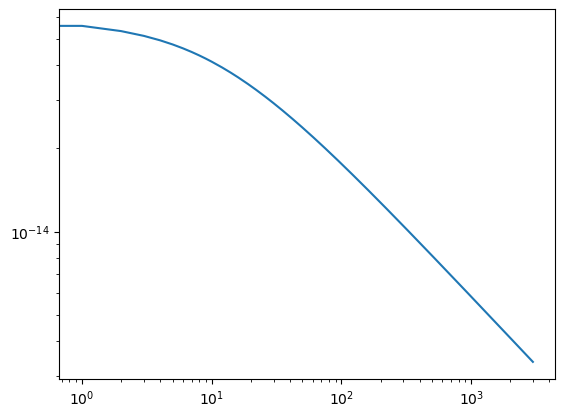

<built-in method residuals of libstempo.libstempo.tempopulsar object at 0x703d06bf0ea0>
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


Results for PSR J0030+0451


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       0.133000000003084         0.133000000002957         1.2145e-11    -1.2729e-13   Y
RAJ (hms)       00:30:28.8812821           00:30:28.8812821         1.6701e-07    -1.7503e-09  
DECJ (rad)      -0.0847963268103388       -0.0847963268099811       2.7735e-11    3.5774e-13    Y
DECJ (dm

<Figure size 640x480 with 0 Axes>

In [4]:
psrs = []
Amp = 2e-14
gamma = 13./3.
howml = 10

for ii in range(0,Npsr):

    # years of observations>
    psr = LT.fakepulsar(parfile=parfiles[ii], obstimes=np.arange(53000,53000+25*365.25,28.), toaerr=0.01)

    # We now remove the computed residuals from the TOAs, obtaining (in effect) a perfect realization of the deterministic timing model. The pulsar parameters will have changed somewhat, so `make_ideal` calls `fit()` on the pulsar object.
    LT.make_ideal(psr)
    #Generate white noise
    LT.add_efac(psr,efac=1.0)

    # add to list
    psrs.append(psr)
    

#LT.createGWB(psrs, Amp=Amp, gam=gamma, howml=100)

#make spectrum
#define the spectrum

r = 10**(-13.1)
nt = 2.4
fstar = 7.7*1e-17
freq = createFreq(psrs, howml=howml)
spec = 1e-8 * (freq/const.fyr)*10
#spec = 8e-16*(r/0.032)*(freq/fstar)**nt

#spec = 1e-50*np.ones(len(freq))
#spec[2*howml] = 3e-5*np.ones(1)
userSpec = np.asarray([freq, spec]).T

#userSpec is in Omega_GW units; freq, spec

#createGWB(psrs, Amp=Amp, gam=gamma, howml=howml, userSpec=userSpec)
createGWB(psrs, Amp=Amp, gam=gamma, howml=howml, userSpec=userSpec, noCorr=True)
print(psrs[0].residuals)    

for Psr in psrs:
    
    Psr.savepar("epta_sim_1/" + Psr.name + '.par')
    Psr.savetim("epta_sim_1/" + Psr.name + '.tim')
    T.purgetim("epta_sim_1/" + Psr.name + '.tim')


In [5]:
parfiles = sorted(glob.glob('epta_sim_1/*.par'))
timfiles = sorted(glob.glob('epta_sim_1/*.tim'))

psrs = []
ephemeris = None
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t)
    psrs.append(psr)

dual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       1.63099999999993          1.63099999999993          3.9031e-12    -3.3307e-15   Y
RAJ (hms)       06:13:47.8599326           06:13:47.8599326         5.3671e-08    -4.58e-11    
DECJ (rad)      0.0352036731913504        0.0352036731914052        8.6374e-12    5.4776e-14    Y
DECJ (dms)      +02:01:01.27883           +02:01:01.27883           1.7816e-06    1.1298e-08   
F0 (s^-1)       205.530696088297          205.530696088297          1.9933e-15    0             Y
F1 (s^-2)       -4.30646577828695e-16     -4.30646577814067e-16     5.0478e-24    1.4627e-26    Y
PEPOCH (MJ

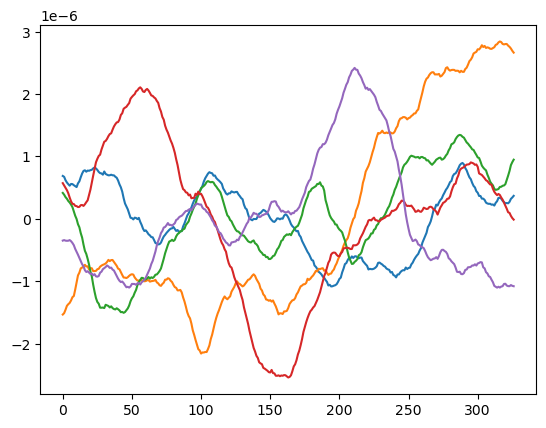

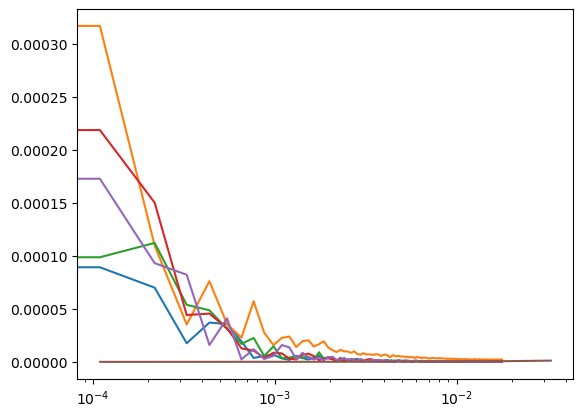

In [6]:
for j in psrs:
    plt.plot(j.residuals)
plt.show()

freq_lst = np.fft.fftfreq(len(psrs[1].residuals), 28)
for j in psrs:
    plt.plot(freq_lst[:int(len(np.fft.fft(j.residuals))/2)], np.abs(np.fft.fft(j.residuals))[:int(len(np.fft.fft(j.residuals))/2)])
    plt.xscale("log")
plt.plot(userSpec[:,0]*24*3600, userSpec[:,1])
plt.show()

In [7]:
# find the maximum time span to set GW frequency sampling
Tspan = model_utils.get_tspan(psrs)

# Here we build the signal model
# First we add the timing model
s = gp_signals.TimingModel()

# Then we add the white noise
# We use different white noise parameters for every backend/receiver combination
# The white noise parameters are held constant
efac = parameter.Constant(1.0)
s += white_signals.MeasurementNoise(efac=efac)

# Finally, we add the common red noise, which is modeled as a Fourier series with 30 frequency components
# The common red noise has a power-law PSD with spectral index of 4.33
s += blocks.common_red_noise_block(psd='spectrum', prior='log-uniform', Tspan=Tspan,
                                   components=40, name='gw_crn', orf = None)
#s += blocks.red_noise_block(psd='spectrum', prior='log-uniform', components=30)

# We set up the PTA object using the signal we defined above and the pulsars
pta = signal_base.PTA([s(p) for p in psrs])

In [8]:
def run_sampler(pta, outdir = ''):

    N = int(1e5)                                    # number of samples
    x0 = np.hstack(p.sample() for p in pta.params)  # initial parameter vector
    ndim = len(x0)                                  # number of dimensions
    print('x0 =', x0)

    # initial jump covariance matrix
    cov = np.diag(np.ones(ndim) * 0.01**2)
    
    #initialize the sampler object
    sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, outDir=outdir, resume=False)
    
    # additional jumps
    jp = sp.JumpProposal(pta)
    sampler.addProposalToCycle(jp.draw_from_prior, 5)
    
    sel_sig = ["rn", "red_noise", "dm_gp", "fcn", "chrom-rn", "srn", "dm_srn", "freechrom-srn", "chrom-srn",
                        "dm-expd", "freechrom-expd", "chrom-expd",
                        "dm-y", "freechrom-y", "chrom-y",
                        "gw"]
    for s in sel_sig:
        if any([s in p for p in pta.param_names]):
            #pnames = [p.name for p in pta.params if s in p.name]
            #print('Adding %s prior draws with parameters :'%s, pnames, '\n')
            print('Adding %s prior draws.'%s)
            sampler.addProposalToCycle(jp.draw_from_par_prior(s), 10)

        
    sampler.sample(x0, N, SCAMweight=40, AMweight=25, DEweight=55) # these weights relate to frequency of jumps

    # write a list of the parameters to a text file
    # and a list of the parameter groupings used
    filename = outdir + '/params.txt'
    np.savetxt(filename,list(map(str, pta.param_names)), fmt='%s')
    
    return None

print(pta.params)

run_sampler(pta, "report_sim")

[gw_crn_log10_rho:Uniform(pmin=-18, pmax=-2)[40]]
x0 = [-11.72926003  -6.19792913  -8.10896665 -10.33223485 -10.09343515
 -17.43233058  -5.90020565 -11.59764449 -11.83313851 -10.37212421
 -14.34472436 -14.57420956  -7.0518851   -4.13714169  -4.88067553
 -17.9861575  -13.01454303  -8.79271     -3.09207207  -7.96909078
  -8.98791275 -17.52098946  -9.371573   -10.5285235  -15.09045411
  -3.2837324   -5.37642153 -11.60652711 -14.55761557  -8.20000025
  -9.32944041  -8.1545535  -10.84936206  -8.05754559  -8.62803049
  -6.6662942   -5.7293316  -10.26512377  -9.38472812  -2.11389751]
Adding rn prior draws.
Adding gw prior draws.
Finished 0.00 percent in 0.001078 s Acceptance rate = 0

/tmp/ipykernel_13234/2724367598.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/nata/miniconda3/envs/ent15y/lib/python3.9/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log


Finished 10.00 percent in 6.365593 s Acceptance rate = 0.26673Adding DE jump with weight 55
Finished 28.00 percent in 17.546681 s Acceptance rate = 0.373893

KeyboardInterrupt: 

(3e-09, 1e-06)

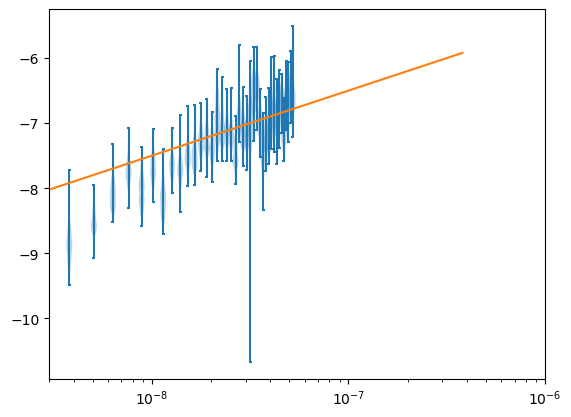

In [9]:
chainname = 'chain_1'
chain = np.loadtxt("report_sim/" + chainname + '.txt')

burn = int(0.3*chain.shape[0])

#corner.corner(chain[burn:,-4],
#                      bins =30,
#                      plot_datapoints=False, plot_density=True, 
#                      plot_contours=False,fill_contours=False,
#                      show_titles = True, use_math_text=True, verbose=True)

fs = (np.arange(40) + 2) / Tspan
parts = plt.violinplot(
    chain[burn:,:-4], positions=fs, widths=0.07*fs)
#plt.savefig("single_bin.png")
#plt.plot(freq, np.log10(spec))
plt.plot(freq, np.log10(spec))
plt.xscale("log")
plt.xlim(3e-9, 1e-6)

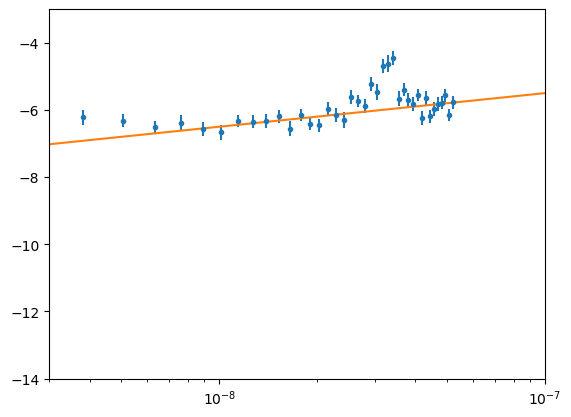

In [11]:
std_lst = np.std(chain[burn:,:-4], axis=0)
mn_lst = np.mean(chain[burn:,:-4], axis=0)
plt.errorbar(fs, mn_lst, std_lst, fmt=".")
np.savetxt("free_spec.txt", np.vstack((fs, mn_lst, std_lst)).T)
plt.plot(freq, np.log10(spec))
plt.xlim(3e-9, 1e-7)
plt.ylim(-14, -3)
plt.xscale("log")

In [11]:
import optimal_statistic as opt_stat

ostat = opt_stat.OptimalStatistic(psrs, pta=pta, orf='hd')

Text(0, 0.5, 'OS SNR')

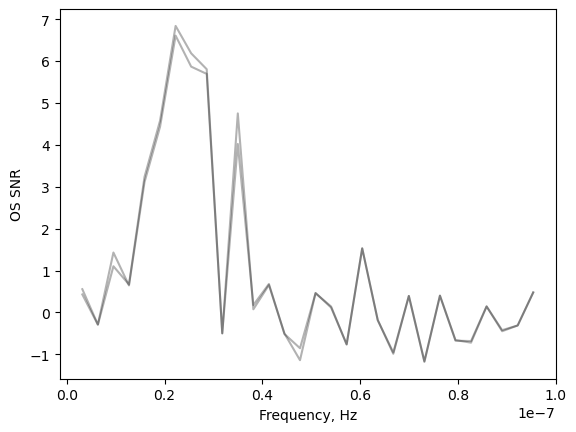

In [11]:
chain = np.genfromtxt("report_sim_hd2/chain_1.txt")
chain_r = chain[burn:, :-4]

param_dict = {}
param_dict[pta.param_names[0][:-2]] = chain_r[1002]


for i,p in enumerate(pta.param_names):
    param_dict[p] = chain_r[300][i]

#print(param_dict)
snr_list = []
#freq_list = 10**np.arange(-9, -6, 0.1)
freq_list = fs
for ii in range(2):
    snr_list = []
    for j in range(len(freq_list)):
        param_dict = {}
        param_dict[pta.param_names[0][:-2]] = chain_r[8*ii]
        for i,p in enumerate(pta.param_names):
            param_dict[p] = chain_r[8*ii]
        xi, rho, sig, OS, OS_sig = ostat.compute_os(params = param_dict, psd = "spectrum", fgw=freq_list[j])
        snr_list = np.append(snr_list, OS/OS_sig)
    plt.plot(fs, snr_list, color="black", alpha=0.3)
#plt.yscale("log")
plt.xlabel("Frequency, Hz")
plt.ylabel("OS SNR")
#plt.savefig("amp_1e-12_hd_uncorr2.png", dpi=300)

In [97]:
dict(zip([pta.param_names[0][:-2]] * len(pta.param_names), chain_r[100]))

{'gw_crn_log10_rho': -8.26933944820348}

In [23]:
param_dict = {}
param_dict[pta.param_names[0][:-2]] = chain_r[100]

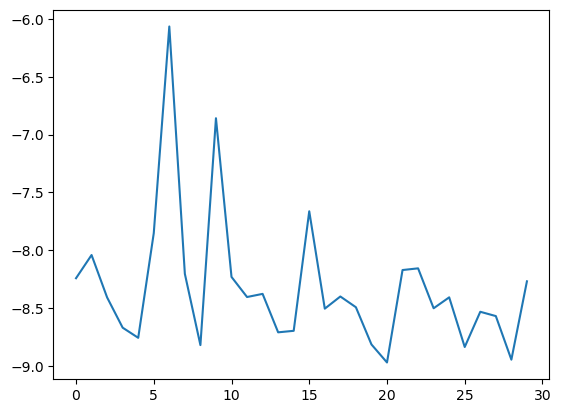

In [26]:
plt.plot(chain_r[100])